In this notebook I will examine the customer data of a telecommunications company and evlauate which classification algorithm will most accurately predict customer churn.

Importing the necessary packages

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
churn= pd.read_csv ("E:\Data\churn_data.csv")
customer=pd.read_csv ("E:\Data\customer_data.csv")
internet=pd.read_csv ("E:\Data\internet_data.csv") 

print(churn)
print(customer)
print(internet)

      customerID  tenure PhoneService        Contract PaperlessBilling  \
0     7590-VHVEG       1           No  Month-to-month              Yes   
1     5575-GNVDE      34          Yes        One year               No   
2     3668-QPYBK       2          Yes  Month-to-month              Yes   
3     7795-CFOCW      45           No        One year               No   
4     9237-HQITU       2          Yes  Month-to-month              Yes   
...          ...     ...          ...             ...              ...   
7037  2569-WGERO      72          Yes        Two year              Yes   
7038  6840-RESVB      24          Yes        One year              Yes   
7039  2234-XADUH      72          Yes        One year              Yes   
7040  4801-JZAZL      11           No  Month-to-month              Yes   
7041  8361-LTMKD       4          Yes  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges Churn  
0              Electronic check           

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7042 entries, 0 to 7041
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7042 non-null   object 
 1   tenure            7042 non-null   int64  
 2   PhoneService      7042 non-null   object 
 3   Contract          7042 non-null   object 
 4   PaperlessBilling  7042 non-null   object 
 5   PaymentMethod     7042 non-null   object 
 6   MonthlyCharges    7042 non-null   float64
 7   TotalCharges      7042 non-null   object 
 8   Churn             7042 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


In [4]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7042 entries, 0 to 7041
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7042 non-null   object
 1   gender         7042 non-null   object
 2   SeniorCitizen  7042 non-null   int64 
 3   Partner        7042 non-null   object
 4   Dependents     7042 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7042 entries, 0 to 7041
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7042 non-null   object
 1   MultipleLines     7042 non-null   object
 2   InternetService   7042 non-null   object
 3   OnlineSecurity    7042 non-null   object
 4   OnlineBackup      7042 non-null   object
 5   DeviceProtection  7042 non-null   object
 6   TechSupport       7042 non-null   object
 7   StreamingTV       7042 non-null   object
 8   StreamingMovies   7042 non-null   object
dtypes: object(9)
memory usage: 495.3+ KB


I was running into an issue where TotalCharges column was recognized as an object even though it contained numerical value.


In [6]:
churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'], errors = 'coerce')
churn.dtypes

customerID           object
tenure                int64
PhoneService         object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Transposing the data will help me line up the customerID row of each df


In [7]:
chtrans =churn.transpose()
cutrans =customer.transpose()
intrans =internet.transpose()

Thes data frames are organizd by customerID so I can concatenate them then eliminate the duplicate rows after.


In [9]:
ccitrans= pd.concat([chtrans, cutrans, intrans], join="inner")
ccitrans.head(23)
 

,0,1,2,3,4,5,6,7,8,9,...,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU,...,6894-LFHLY,9767-FFLEM,0639-TSIQW,8456-QDAVC,7750-EYXWZ,2569-WGERO,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD
tenure,1,34,2,45,2,8,22,10,28,62,...,1,38,67,19,12,72,24,72,11,4
PhoneService,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,...,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes
Contract,Month-to-month,One year,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month,Month-to-month,Month-to-month,One year,...,Month-to-month,Month-to-month,Month-to-month,Month-to-month,One year,Two year,One year,One year,Month-to-month,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,...,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check,Electronic check,Credit card (automatic),Mailed check,Electronic check,Bank transfer (automatic),...,Electronic check,Credit card (automatic),Credit card (automatic),Bank transfer (automatic),Electronic check,Bank transfer (automatic),Mailed check,Credit card (automatic),Electronic check,Mailed check
MonthlyCharges,29.85,56.95,53.85,42.3,70.7,99.65,89.1,29.75,104.8,56.15,...,75.75,69.5,102.95,78.7,60.65,21.15,84.8,103.2,29.6,74.4
TotalCharges,29.85,1889.5,108.15,1840.75,151.65,820.5,1949.4,301.9,3046.05,3487.95,...,75.75,2625.25,6886.25,1495.1,743.3,1419.4,1990.5,7362.9,346.45,306.6
Churn,No,No,Yes,No,Yes,Yes,No,No,Yes,No,...,Yes,No,Yes,No,No,No,No,No,No,Yes
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU,...,6894-LFHLY,9767-FFLEM,0639-TSIQW,8456-QDAVC,7750-EYXWZ,2569-WGERO,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD


Here I drop the extra customerID rows then transpose the data set to get it back to its original orientation.



In [11]:
cci = ccitrans.drop_duplicates().transpose()
cci = cci.dropna()
cci 

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.3,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.7,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,2569-WGERO,72,Yes,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,Female,...,No,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
7038,6840-RESVB,24,Yes,One year,Yes,Mailed check,84.8,1990.5,No,Male,...,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,72,Yes,One year,Yes,Credit card (automatic),103.2,7362.9,No,Female,...,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,11,No,Month-to-month,Yes,Electronic check,29.6,346.45,No,Female,...,Yes,Yes,No phone service,DSL,Yes,No,No,No,No,No


A majority of these features are cetegorical but there are 3 rows with numerical values.
Here I change the data types of those rows into float


In [13]:
cci = cci.astype({'TotalCharges': float})
cci = cci.astype({'MonthlyCharges': float})
cci = cci.astype({'tenure': float},)
cci.dtypes

customerID           object
tenure              float64
PhoneService         object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
dtype: object

Now we will examine the missing data.  False means data is not missin.
False means data is not missing.



In [14]:
cci.replace("?", np.nan, inplace = True)
cci.head(5)
missing = cci.isnull()
missing.head(5)

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Since the amount of False values are listed at 7031 we can see that this data set is not missing values.

In [15]:
for column in missing.columns.values.tolist():
    print(column)
    print (missing[column].value_counts())

customerID
False    7031
Name: customerID, dtype: int64
tenure
False    7031
Name: tenure, dtype: int64
PhoneService
False    7031
Name: PhoneService, dtype: int64
Contract
False    7031
Name: Contract, dtype: int64
PaperlessBilling
False    7031
Name: PaperlessBilling, dtype: int64
PaymentMethod
False    7031
Name: PaymentMethod, dtype: int64
MonthlyCharges
False    7031
Name: MonthlyCharges, dtype: int64
TotalCharges
False    7031
Name: TotalCharges, dtype: int64
Churn
False    7031
Name: Churn, dtype: int64
gender
False    7031
Name: gender, dtype: int64
SeniorCitizen
False    7031
Name: SeniorCitizen, dtype: int64
Partner
False    7031
Name: Partner, dtype: int64
Dependents
False    7031
Name: Dependents, dtype: int64
MultipleLines
False    7031
Name: MultipleLines, dtype: int64
InternetService
False    7031
Name: InternetService, dtype: int64
OnlineSecurity
False    7031
Name: OnlineSecurity, dtype: int64
OnlineBackup
False    7031
Name: OnlineBackup, dtype: int64
DeviceProtection

This data set contains many catergorical values that must be encoded to use with my model. 

In [17]:
obj_df = cci.select_dtypes(include=['object']).copy() 

In [18]:
for column in obj_df:
    #This changes the data types from object to category
    obj_df[column] = obj_df[column].astype('category')
    
    
    #This creates new columns with our categorical data encoded
    obj_df[column+'code'] = obj_df[column].cat.codes
    


In [19]:
#Checking the correlation between churn and the other variables
obj_df.corr()[5:6]

,customerIDcode,PhoneServicecode,Contractcode,PaperlessBillingcode,PaymentMethodcode,Churncode,gendercode,Partnercode,Dependentscode,MultipleLinescode,InternetServicecode,OnlineSecuritycode,OnlineBackupcode,DeviceProtectioncode,TechSupportcode,StreamingTVcode,StreamingMoviescode
Churncode,-0.017916,0.01172,-0.396095,0.19154,0.107745,1.0,-0.008461,-0.150078,-0.163193,0.037962,-0.047084,-0.288978,-0.195398,-0.177801,-0.282159,-0.036209,-0.038709


In [20]:
ccifloat = cci.select_dtypes(include=['float']).copy()
ccifloat 

,tenure,MonthlyCharges,TotalCharges
0,1.0,29.85,29.85
1,34.0,56.95,1889.50
2,2.0,53.85,108.15
3,45.0,42.30,1840.75
4,2.0,70.70,151.65
...,...,...,...
7037,72.0,21.15,1419.40
7038,24.0,84.80,1990.50
7039,72.0,103.20,7362.90
7040,11.0,29.60,346.45


In [21]:
obj_df.dtypes

customerID              category
PhoneService            category
Contract                category
PaperlessBilling        category
PaymentMethod           category
Churn                   category
gender                  category
Partner                 category
Dependents              category
MultipleLines           category
InternetService         category
OnlineSecurity          category
OnlineBackup            category
DeviceProtection        category
TechSupport             category
StreamingTV             category
StreamingMovies         category
customerIDcode             int16
PhoneServicecode            int8
Contractcode                int8
PaperlessBillingcode        int8
PaymentMethodcode           int8
Churncode                   int8
gendercode                  int8
Partnercode                 int8
Dependentscode              int8
MultipleLinescode           int8
InternetServicecode         int8
OnlineSecuritycode          int8
OnlineBackupcode            int8
DeviceProt

In [22]:
obj_int = obj_df.select_dtypes(include=['int8']).copy()
obj_int

,PhoneServicecode,Contractcode,PaperlessBillingcode,PaymentMethodcode,Churncode,gendercode,Partnercode,Dependentscode,MultipleLinescode,InternetServicecode,OnlineSecuritycode,OnlineBackupcode,DeviceProtectioncode,TechSupportcode,StreamingTVcode,StreamingMoviescode
0,0,0,1,2,0,0,1,0,1,0,0,2,0,0,0,0
1,1,1,0,3,0,1,0,0,0,0,2,0,2,0,0,0
2,1,0,1,3,1,1,0,0,0,0,2,2,0,0,0,0
3,0,1,0,0,0,1,0,0,1,0,2,0,2,2,0,0
4,1,0,1,2,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,1,2,1,0,0,0,0,0,0,2,1,1,1,1,1,1
7038,1,1,1,3,0,1,1,1,2,0,2,0,2,2,2,2
7039,1,1,1,1,0,0,1,1,2,1,0,2,2,0,2,2
7040,0,0,1,2,0,0,1,1,1,0,2,0,0,0,0,0


In [23]:
obj_df.corr()

,customerIDcode,PhoneServicecode,Contractcode,PaperlessBillingcode,PaymentMethodcode,Churncode,gendercode,Partnercode,Dependentscode,MultipleLinescode,InternetServicecode,OnlineSecuritycode,OnlineBackupcode,DeviceProtectioncode,TechSupportcode,StreamingTVcode,StreamingMoviescode
customerIDcode,1.000000,-0.006957,0.016096,-0.002150,0.011622,-0.017916,0.006322,-0.026598,-0.011931,0.004407,-0.012317,0.013870,-0.003055,-0.006611,0.001890,-0.007546,-0.017105
PhoneServicecode,-0.006957,1.000000,0.002946,0.016658,-0.005431,0.011720,-0.007562,0.018443,-0.001047,-0.020459,0.387262,-0.014230,0.024090,0.004661,-0.018203,0.056345,0.042976
Contractcode,0.016096,0.002946,1.000000,-0.175700,-0.229382,-0.396095,-0.000127,0.294382,0.240751,0.111278,0.099558,0.373783,0.280918,0.349889,0.424893,0.226630,0.232285
PaperlessBillingcode,-0.002150,0.016658,-0.175700,1.000000,-0.061187,0.191540,-0.012020,-0.013844,-0.110062,0.165443,-0.138194,-0.157919,-0.012578,-0.037749,-0.113804,0.097257,0.083778
PaymentMethodcode,0.011622,-0.005431,-0.229382,-0.061187,1.000000,0.107745,0.017154,-0.156469,-0.042134,-0.176846,0.084554,-0.096326,-0.125779,-0.136235,-0.104281,-0.104568,-0.111798
Churncode,-0.017916,0.011720,-0.396095,0.191540,0.107745,1.000000,-0.008461,-0.150078,-0.163193,0.037962,-0.047084,-0.288978,-0.195398,-0.177801,-0.282159,-0.036209,-0.038709
gendercode,0.006322,-0.007562,-0.000127,-0.012020,0.017154,-0.008461,1.000000,-0.001243,0.010442,-0.006769,-0.002260,-0.015101,-0.011777,0.001173,-0.006893,-0.005786,-0.009082
Partnercode,-0.026598,0.018443,0.294382,-0.013844,-0.156469,-0.150078,-0.001243,1.000000,0.452223,0.142600,0.000536,0.150835,0.152925,0.165814,0.126706,0.136859,0.130084
Dependentscode,-0.011931,-0.001047,0.240751,-0.110062,-0.042134,-0.163193,0.010442,0.452223,1.000000,-0.025069,0.044047,0.151355,0.090145,0.079850,0.132682,0.046326,0.022196
MultipleLinescode,0.004407,-0.020459,0.111278,0.165443,-0.176846,0.037962,-0.006769,0.142600,-0.025069,1.000000,-0.108833,0.007506,0.117148,0.122811,0.011140,0.175594,0.181895


In [24]:
ccifloat.transpose()

code_df = pd.concat([ccifloat.transpose(), obj_int.transpose()], join="inner").transpose()
code_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7031 entries, 0 to 7041
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tenure                7031 non-null   float64
 1   MonthlyCharges        7031 non-null   float64
 2   TotalCharges          7031 non-null   float64
 3   PhoneServicecode      7031 non-null   float64
 4   Contractcode          7031 non-null   float64
 5   PaperlessBillingcode  7031 non-null   float64
 6   PaymentMethodcode     7031 non-null   float64
 7   Churncode             7031 non-null   float64
 8   gendercode            7031 non-null   float64
 9   Partnercode           7031 non-null   float64
 10  Dependentscode        7031 non-null   float64
 11  MultipleLinescode     7031 non-null   float64
 12  InternetServicecode   7031 non-null   float64
 13  OnlineSecuritycode    7031 non-null   float64
 14  OnlineBackupcode      7031 non-null   float64
 15  DeviceProtectioncode 

In [25]:
code_df.dropna()
code_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7031 entries, 0 to 7041
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tenure                7031 non-null   float64
 1   MonthlyCharges        7031 non-null   float64
 2   TotalCharges          7031 non-null   float64
 3   PhoneServicecode      7031 non-null   float64
 4   Contractcode          7031 non-null   float64
 5   PaperlessBillingcode  7031 non-null   float64
 6   PaymentMethodcode     7031 non-null   float64
 7   Churncode             7031 non-null   float64
 8   gendercode            7031 non-null   float64
 9   Partnercode           7031 non-null   float64
 10  Dependentscode        7031 non-null   float64
 11  MultipleLinescode     7031 non-null   float64
 12  InternetServicecode   7031 non-null   float64
 13  OnlineSecuritycode    7031 non-null   float64
 14  OnlineBackupcode      7031 non-null   float64
 15  DeviceProtectioncode 

In [26]:
code_df.corr()[7:8]

,tenure,MonthlyCharges,TotalCharges,PhoneServicecode,Contractcode,PaperlessBillingcode,PaymentMethodcode,Churncode,gendercode,Partnercode,Dependentscode,MultipleLinescode,InternetServicecode,OnlineSecuritycode,OnlineBackupcode,DeviceProtectioncode,TechSupportcode,StreamingTVcode,StreamingMoviescode
Churncode,-0.353989,0.193005,-0.199374,0.01172,-0.396095,0.19154,0.107745,1.0,-0.008461,-0.150078,-0.163193,0.037962,-0.047084,-0.288978,-0.195398,-0.177801,-0.282159,-0.036209,-0.038709


<AxesSubplot:>

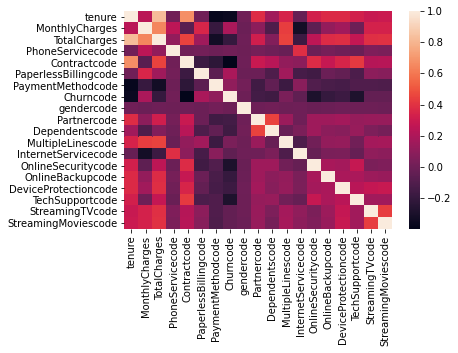

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(code_df.corr())

In [28]:
#Creating a dataframe with our y and 6 variables of descending correlation
model = code_df[['Churncode','Contractcode' ,'tenure','OnlineSecuritycode','TechSupportcode','OnlineBackupcode','PaperlessBillingcode']]

In [29]:
Cont_key = obj_df[['Contract','Contractcode']].drop_duplicates()
Cont_key

,Contract,Contractcode
0,Month-to-month,0
1,One year,1
11,Two year,2


In [30]:
OSec_key = obj_df[['OnlineSecurity','OnlineSecuritycode']].drop_duplicates()
OSec_key

,OnlineSecurity,OnlineSecuritycode
0,No,0
1,Yes,2
11,No internet service,1


In [31]:
Tech_key = obj_df[['TechSupport','TechSupportcode']].drop_duplicates()
Tech_key

,TechSupport,TechSupportcode
0,No,0
3,Yes,2
11,No internet service,1


In [32]:
OBac =  obj_df[['OnlineBackup','OnlineBackupcode']].drop_duplicates()
OBac

,OnlineBackup,OnlineBackupcode
0,Yes,2
1,No,0
11,No internet service,1


In [33]:
Papb = obj_df[['PaperlessBilling','PaperlessBillingcode']].drop_duplicates()
Papb

,PaperlessBilling,PaperlessBillingcode
0,Yes,1
1,No,0


In [34]:
#Defining X and y of the data set
X = np.asarray(model.drop('Churncode', axis = 'columns'))
y = np.asarray(model['Churncode'])


In [35]:
#Normalizing the dataset
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.8265978 , -1.28013284, -0.91770134, -0.92413045,  1.24273344,
         0.82903861],
       [ 0.37418921,  0.06450127,  1.40831096, -0.92413045, -1.02914873,
        -1.20621644],
       [-0.8265978 , -1.23938635,  1.40831096, -0.92413045,  1.24273344,
         0.82903861],
       [ 0.37418921,  0.51271264,  1.40831096,  1.39725619, -1.02914873,
        -1.20621644],
       [-0.8265978 , -1.23938635, -0.91770134, -0.92413045, -1.02914873,
         0.82903861]])

In [36]:
# We split the X into train and test to find the best k
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_val.shape,  y_val.shape)

Train set: (5624, 6) (5624,)
Validation set: (1407, 6) (1407,)


Model Evaluation

In [37]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

K Nearest Neighbor

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
metrics.accuracy_score(y_val, neigh.predict(X_val))
#Considering anything above .55 is profitable this model should suffice.

0.7711442786069652

[0.74129353 0.75977257 0.76687989 0.76190476 0.77114428 0.77114428
 0.77540867 0.79317697 0.78109453 0.77896233 0.77256574 0.78109453
 0.77683014 0.77896233 0.7782516 ]


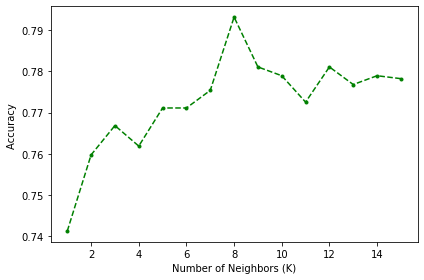

In [39]:
k = 15
accuracy_vector = np.zeros(k)

for i in range(1,k+1):
    #print(i)
    #Create an instance of the KNN
    kneigh = KNeighborsClassifier(n_neighbors=i)
    #Fit the instance with the training data
    kneigh.fit(X_train, y_train)
    #predict the output for the val data
    y_hat = kneigh.predict(X_val)
    #Model evaluation
    accuracy_vector[i-1] = accuracy_score(y_val,y_hat)

    
print(accuracy_vector)

#Plot accuracy vs k
plt.plot(range(1,k+1),accuracy_vector,'--.g')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [40]:
jaccard_knn = jaccard_score(y_val, neigh.predict(X_val), average = 'micro')
accuracy_knn = metrics.accuracy_score(y_val, neigh.predict(X_val))
f1_knn = f1_score(y_val, neigh.predict(X_val), average='weighted')
scores = dict()
scores['KNN']= [accuracy_knn,jaccard_knn, f1_knn, None]
scores

{'KNN': [0.7711442786069652, 0.6275303643724697, 0.7631294598742608, None]}

Decision Tree

[0.72352523 0.75692964 0.77185501 0.77185501 0.77327647 0.78393746
 0.78535892 0.77256574 0.76403696 0.76474769]


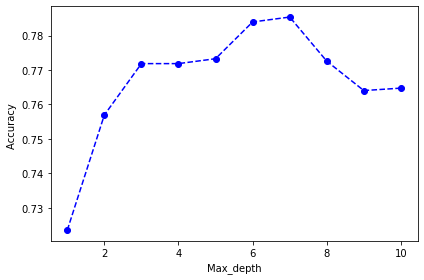

In [41]:
from sklearn.tree import DecisionTreeClassifier
md = 10   # Interval for max depth 1:1:10

accuracy_vector_trees = np.zeros(md)

for i in range(1,md+1):
    # Create an instance of the DecisionTreeClassifier
    Dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth = i)
    # Fit the instance with the training data
    Dec_tree.fit(X_train, y_train)
    # predict the output for the val data
    y_hat = Dec_tree.predict(X_val)
    #Model evaluation
    accuracy_vector_trees[i-1] = accuracy_score(y_val,y_hat)


print(accuracy_vector_trees)

#Plot accuracy vs max depth
plt.plot(range(1,md+1),accuracy_vector_trees,'--ob')
plt.ylabel('Accuracy ')
plt.xlabel('Max_depth')
plt.tight_layout()
plt.show()

# The minimum value that improves the results is max_depth = 6

In [42]:
dtree = DecisionTreeClassifier(criterion="entropy", max_depth = 1)
dtree # it shows the default parameters
dtree.fit(X_train,y_train)
predTree = dtree.predict(X_val)
print("DecisionTrees's Accuracy : ", metrics.accuracy_score(y_val, predTree))

DecisionTrees's Accuracy :  0.7235252309879175


In [43]:
jaccard_dt = jaccard_score(y_val, dtree.predict(X_val), average = 'micro')
accuracy_dt = metrics.accuracy_score(y_val, dtree.predict(X_val))
f1_dt = f1_score(y_val, dtree.predict(X_val), average='micro')
scores['Decision Tree']= [accuracy_dt,jaccard_dt, f1_dt, None]
scores

{'KNN': [0.7711442786069652, 0.6275303643724697, 0.7631294598742608, None],
 'Decision Tree': [0.7235252309879175,
  0.566815144766147,
  0.7235252309879175,
  None]}

Support Vector Machine

[0.78606965 0.78535892 0.78962331 0.71997157]


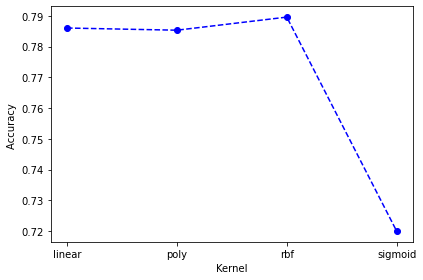

In [44]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

Kernels = ['linear','poly','rbf','sigmoid']

accuracy_vector_svm = np.zeros(len(Kernels))

for i in range(1,len(Kernels)+1):
    # Create an instance of the SVM
    svm_insta = svm.SVC(kernel = str(Kernels[i-1]))
    # Fit the instance with the training data
    svm_insta.fit(X_train, y_train)
    # predict the output for the val data
    y_hat = svm_insta.predict(X_val)
    #Model evaluation
    accuracy_vector_svm[i-1] = accuracy_score(y_val,y_hat)

    
print(accuracy_vector_svm)

#Plot accuracy vs kernel
plt.plot(Kernels,accuracy_vector_svm,'--ob')
plt.ylabel('Accuracy ')
plt.xlabel('Kernel')
plt.tight_layout()
plt.show()
#We can see that linear provides the highest accuracy           ......

In [45]:
jaccard_svm = jaccard_score(y_val, clf.predict(X_val), average = 'micro')
accuracy_svm = metrics.accuracy_score(y_val, clf.predict(X_val))
f1_svm = f1_score(y_val, clf.predict(X_val), average='micro')
scores['SVM']= [accuracy_svm,jaccard_svm, f1_svm, None]
scores

{'KNN': [0.7711442786069652, 0.6275303643724697, 0.7631294598742608, None],
 'Decision Tree': [0.7235252309879175,
  0.566815144766147,
  0.7235252309879175,
  None],
 'SVM': [0.7860696517412935, 0.6475409836065574, 0.7860696517412936, None]}

Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
#Create an instance of the logistic Regressor object
LogRe = LogisticRegression(C=0.01, solver='liblinear')
#Fit the instance with the training data
LogRe.fit(X_train, y_train)
#predict the output for the val data
y_hat_log = LogRe.predict(X_val)
#Model evaluation
print(accuracy_score(y_val,y_hat))

0.7199715707178393


In [47]:
y_hat_test = LogRe.predict(X_val)

jaccard_lr = jaccard_score(y_val,y_hat_test)
accuracy_lr = accuracy_score(y_val,y_hat_test)
f1_lr = f1_score(y_val,y_hat_test, average='micro')

y_hat_test_prob = LogRe.predict_proba(X_val)


logloss_lr = log_loss(y_val, y_hat_test_prob)
scores['LR']= [accuracy_lr,jaccard_lr, f1_lr, logloss_lr]
scores

{'KNN': [0.7711442786069652, 0.6275303643724697, 0.7631294598742608, None],
 'Decision Tree': [0.7235252309879175,
  0.566815144766147,
  0.7235252309879175,
  None],
 'SVM': [0.7860696517412935, 0.6475409836065574, 0.7860696517412936, None],
 'LR': [0.7803837953091685,
  0.3628865979381443,
  0.7803837953091685,
  0.44147579705633216]}

In [48]:
report = pd.DataFrame(scores.values(), index=scores.keys(), columns=['Accuracy','Jaccard', 'F1-score', 'LogLoss'])
report

,Accuracy,Jaccard,F1-score,LogLoss
KNN,0.771144,0.627530,0.763129,NaN
Decision Tree,0.723525,0.566815,0.723525,NaN
SVM,0.786070,0.647541,0.786070,NaN
LR,0.780384,0.362887,0.780384,0.441476
